In [1]:
write = False # log this version as new
MODEL_DESCRIPTION = "Increase KL weight"

In [2]:
import os
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sys import stdout
from datetime import datetime
import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback
from astropy.io import fits
import random
from DataMaker import HDF5ImageGenerator

In [3]:
from tensorflow.keras.models import Model
from keras import backend as K
from tensorflow.keras.layers import Cropping2D, ZeroPadding2D, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape
import tensorflow_probability as tfp
from tensorflow_probability import layers as tfpl
from tensorflow_probability import distributions as tfd
from tensorflow.nn import leaky_relu
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

In [4]:
LATENT_DIM = 512
BASE_DEPTH = 8
IMAGE_SHAPE = (5, 127, 127)
BATCH_SIZE = 512
EPOCHS = 5
CHECKPOINTS_TO_SAVE = 4
KL_WEIGHT = 1e-6
# Good value: 1e-6

In [5]:
gpus = tf.config.list_physical_devices('GPU');
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 20000)]);
        logical_gpus = tf.config.experimental.list_logical_devices('GPU');
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

2023-01-22 01:11:09.123725: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


1 Physical GPUs, 1 Logical GPUs


2023-01-22 01:11:09.135101: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 01:11:09.136143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 01:11:09.187549: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-22 01:11:09.189725: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [6]:
now = datetime.now()

DATASET_NAME = "HSC_v6_small"
MODEL_TYPE = "VAE"
MODEL_VERSION = "v1.0"
MODEL_SUBVERSION = "v1.0." + now.strftime("%Y%m%d_%H_%M_%S")

model_id = '_'.join([DATASET_NAME, MODEL_TYPE, MODEL_VERSION])
model_path = os.path.join('/models', model_id, MODEL_SUBVERSION, 'model')
checkpoints_path = os.path.join('/models', model_id, MODEL_SUBVERSION, 'checkpoints')
logs_path = os.path.join('/logs', model_id, MODEL_SUBVERSION)
predictions_path = os.path.join('/predictions', model_id, MODEL_SUBVERSION)
weights_path = model_path + '/weights.h5'

os.makedirs(model_path, exist_ok = True)
os.makedirs(checkpoints_path, exist_ok = True)
os.makedirs(logs_path, exist_ok = True)
os.makedirs(predictions_path, exist_ok = True)

if write == True:
    with open("/models/README.md", "a") as myfile:
        myfile.write(MODEL_TYPE + " " + MODEL_SUBVERSION + " - " + MODEL_DESCRIPTION + " - B. Li" + "\n")
else:
    with open("/models/README.md", "a") as myfile:
        myfile.write(MODEL_TYPE + " " + MODEL_SUBVERSION + " - ... "+ " - B. Li" + "\n")

In [7]:
args_gen = {'X_key': 'image',
    'y_key': 'specz_redshift',
    'scaler': False,
    'labels_encoding': False,
    'batch_size': BATCH_SIZE,
    'mode': 'train',
    'shuffle': False}

train_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_training.hdf5', **args_gen)
val_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_validation.hdf5', **args_gen)
test_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_testing.hdf5', **args_gen)

In [8]:
n = BATCH_SIZE
l = len(train_gen._indices)

In [9]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(LATENT_DIM), scale = 0.1), reinterpreted_batch_ndims = 1)

images = Input(shape = IMAGE_SHAPE)
redshifts = Input(shape = 1,)
conv1 = Conv2D(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
            padding = 'same', data_format = 'channels_first')(images)
conv2 = Conv2D(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
            padding = 'same', data_format = 'channels_first')(conv1)
flatten = Flatten()(conv2)
dense1 = Dense(1024, activation = None)(flatten)
dense2 = tf.keras.layers.Dense(32, activation = "relu")(redshifts)
dense3 = tf.keras.layers.Dense(32, activation = "relu")(dense2)
concat = tf.keras.layers.Concatenate()([dense1, dense3])
dense4 = Dense(tfpl.MultivariateNormalTriL.params_size(LATENT_DIM), activation = None)(concat)
z = tfpl.MultivariateNormalTriL(LATENT_DIM,
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight = KL_WEIGHT))(dense4)
encoder = Model([images, redshifts], z)

zc = tf.keras.layers.Concatenate()([z, redshifts])

In [10]:
dense5 = Dense(8 * LATENT_DIM * 32 * 32, activation = None)
reshape = Reshape((8 * LATENT_DIM, 32, 32))
conv3 = Conv2DTranspose(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
                    padding = 'same', data_format = 'channels_first')
conv4 = Conv2DTranspose(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
                    padding = 'same', data_format = 'channels_first')
conv5 = Conv2DTranspose(BASE_DEPTH, 3, strides = 1, activation = leaky_relu, 
                    padding = 'same', data_format = 'channels_first')
conv6 = Conv2D(IMAGE_SHAPE[0], 3, strides = 1, activation = None, 
           padding = 'same', data_format = 'channels_first')
cropping = Cropping2D(cropping=((0, 1), (0, 1)), data_format = 'channels_first')
outputs = Reshape(IMAGE_SHAPE)

In [11]:
dense5_model = dense5(zc)
reshape_model = reshape(dense5_model)
conv3_model = conv3(reshape_model)
conv4_model = conv4(conv3_model)
conv5_model = conv5(conv4_model)
conv6_model = conv6(conv5_model)
cropping_model = cropping(conv6_model)
outputs_model = outputs(cropping_model)

In [12]:
model = Model(inputs = [images, redshifts], outputs = [outputs_model])

In [13]:
latents = Input(shape = (LATENT_DIM + 1, ))
dense5_decoder = dense5(latents)
reshape_decoder = reshape(dense5_decoder)
conv3_decoder = conv3(reshape_decoder)
conv4_decoder = conv4(conv3_decoder)
conv5_decoder = conv5(conv4_decoder)
conv6_decoder = conv6(conv5_decoder)
cropping_decoder = cropping(conv6_decoder)
outputs_decoder = outputs(cropping_decoder)

In [14]:
decoder = Model(latents, outputs_decoder)

In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 127, 127  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 8, 64, 64)    368         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 32, 32)    584         ['conv2d[0][0]']                 
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                         

In [16]:
model.compile(optimizer = 'adam', loss = 'mse')

In [44]:
run = neptune.init_run(
    name = MODEL_SUBVERSION,
    project = "astro-data-lab/VAE",
    api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxOGFlZGMxOC04MWU5LTQ2NDctYjlhZS05NGE2NGQ0NmIzMmEifQ==",
)  # your credentials

# logs_callback = TensorBoard(log_dir = logs_path)

weights_callback = ModelCheckpoint(filepath = os.path.join(checkpoints_path, 'weights_epoch{epoch}.hdf5'), save_freq = int(EPOCHS/CHECKPOINTS_TO_SAVE), save_weights_only = True)

LR_callback = ReduceLROnPlateau()

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs_path, histogram_freq = 1)

neptune_callback = NeptuneCallback(run = run)

https://app.neptune.ai/astro-data-lab/VAE/e/VAE-91
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [18]:
history = model.fit(train_gen, epochs = EPOCHS, callbacks = [weights_callback, LR_callback, neptune_callback], validation_data = val_gen, verbose = 1)

Epoch 1/5


2023-01-22 01:11:19.901694: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-01-22 01:13:26.806862: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2023-01-22 01:16:17.620976: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-22 01:18:20.896709: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-22 01:18:20.896837: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be pri

  1/392 [..............................] - ETA: 46:51:13 - loss: 6.7418

2023-01-22 01:18:28.686825: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2155872256 exceeds 10% of free system memory.


  2/392 [..............................] - ETA: 2:12:47 - loss: 6.0337 

2023-01-22 01:18:48.996424: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2155872256 exceeds 10% of free system memory.


  3/392 [..............................] - ETA: 2:13:45 - loss: 4.5308

2023-01-22 01:19:11.011860: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2155872256 exceeds 10% of free system memory.


  4/392 [..............................] - ETA: 2:14:17 - loss: 4.9590

2023-01-22 01:19:31.540639: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2155872256 exceeds 10% of free system memory.


392/392 [==============================] - 8193s 20s/step - loss: 2.6718 - val_loss: 2.3741 - lr: 0.0010
Epoch 2/5
392/392 [==============================] - 7100s 18s/step - loss: 2.7960 - val_loss: 2.4160 - lr: 0.0010
Epoch 3/5
392/392 [==============================] - 6377s 16s/step - loss: 14.5893 - val_loss: 5.2201 - lr: 0.0010
Epoch 4/5
392/392 [==============================] - 7055s 18s/step - loss: 12.9342 - val_loss: 4.9663 - lr: 0.0010
Epoch 5/5
392/392 [==============================] - 6651s 17s/step - loss: 49.2768 - val_loss: 5.0930 - lr: 0.0010


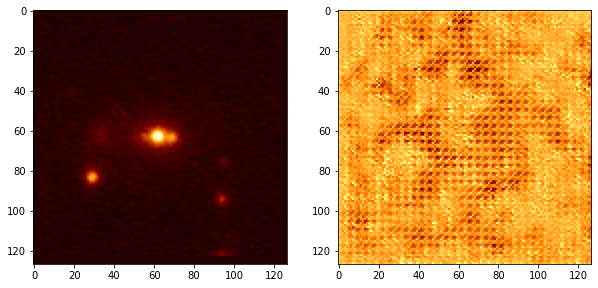

In [55]:
index = 10
z = test_gen[0][0][1][index]
str = np.asarray(encoder([np.array([test_gen[0][0][0][index]]), np.array([test_gen[0][0][1][index]])])[0])
str = np.concatenate((str, np.array([z])))
str = str.reshape(1, LATENT_DIM + 1)
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
axes[0].imshow(test_gen[0][0][0][index][4], cmap = 'afmhot')
axes[1].imshow(decoder([str])[0][4], cmap = 'afmhot')
plt.show()

In [ ]:
num_to_generate = 100
for i in range(1, num_to_generate + 1):
    z = np.round(random.uniform(0, 1), 2)
    str = np.concatenate((np.asarray(prior.sample(1))[0], np.array([z]))).reshape(1, LATENT_DIM + 1)
    hdul = fits.PrimaryHDU(data = decoder.predict([str])[0])
    string = f"/data/CVAE Generated/Full/Test Galaxy z = {z}.fits"
    hdul.writeto(string, overwrite = True)

In [ ]:
# END